Whole Slide Images (WSI) are captured at a very high resolution. In this dataset, 21 anonymised WSI images in Aperio SVS format, of canine carcinoma, are available. The cell annotations are provided in a SQLite3 database. 

Below we extract the dimensions of all the 21 images from the database. 

In [78]:
from SlideRunner.dataAccess.database import Database
import numpy as np

def listOfSlides(DB):
    DB.execute('SELECT uid, filename, width, height from Slides')
    return DB.fetchall()

DB = Database()
DB.open('databases/MITOS_WSI_CMC_COADEL_TR.sqlite')

for slideid,filename, width, height in listOfSlides(DB):
    print(f"Slide ID# {slideid}: {filename} {height} x {width} pixels")


Slide ID# 1: a8773be388e12df89edd.svs 57462 x 61199 pixels
Slide ID# 2: 460906c0b1fe17ea5354.svs 63831 x 136800 pixels
Slide ID# 3: 2d56d1902ca533a5b509.svs 65453 x 70199 pixels
Slide ID# 5: d0423ef9a648bb66a763.svs 85208 x 116999 pixels
Slide ID# 6: 50cf88e9a33df0c0c8f9.svs 87273 x 125999 pixels
Slide ID# 7: da18e7b9846e9d38034c.svs 84305 x 95399 pixels
Slide ID# 8: d7a8af121d7d4f3fbf01.svs 88592 x 111599 pixels
Slide ID# 9: 2191a7aa287ce1d5dbc0.svs 82534 x 98999 pixels
Slide ID# 10: 69a02453620ade0edefd.svs 90076 x 97199 pixels
Slide ID# 11: c4b95da36e32993289cb.svs 84710 x 124199 pixels
Slide ID# 12: fa4959e484beec77543b.svs 84406 x 118799 pixels
Slide ID# 13: 72c93e042d0171a61012.svs 78623 x 122399 pixels
Slide ID# 14: 4eee7b944ad5e46c60ce.svs 47721 x 44999 pixels
Slide ID# 15: b1bdee8e5e3372174619.svs 83745 x 125999 pixels
Slide ID# 16: 3d3d04eca056556b0b26.svs 87152 x 109799 pixels
Slide ID# 17: 084383c18b9060880e82.svs 82153 x 61199 pixels
Slide ID# 18: e09512d530d933e436d5.svs 

Let us load and display a WSI image with some sample annotations.

In [79]:
WSI_filename = 'deb768e5efb9d1dcbc13.svs'
import openslide
slide = openslide.open_slide('WSI/' + WSI_filename)

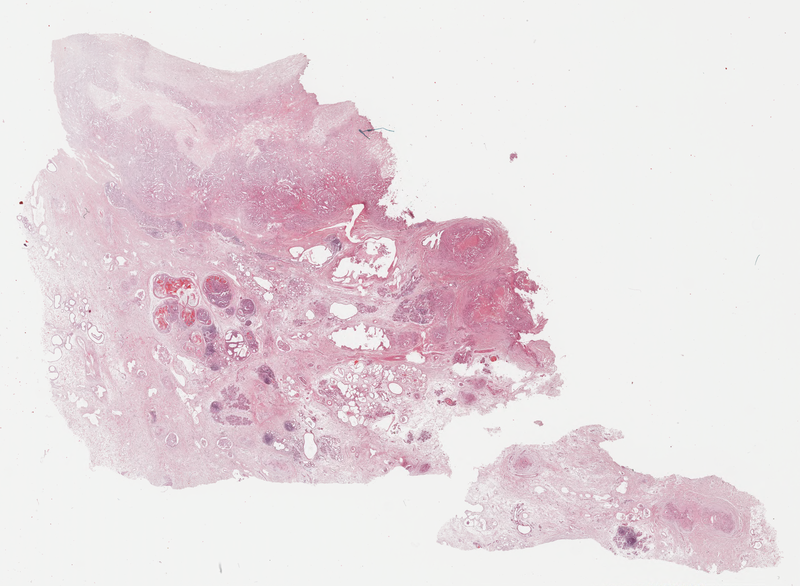

In [80]:
slide.get_thumbnail(size=[800, 800])

Let us load the annotations for this WSI image from the annotations database. 

In [82]:
slideid = DB.findSlideWithFilename(WSI_filename,'')
DB.loadIntoMemory(slideid)

print(f"{WSI_filename} has {len(DB.annotations.keys())} annotations")

deb768e5efb9d1dcbc13.svs has 569 annotations


In [83]:
# Get a few annotations 
DB.annotations.keys()

dict_keys([24634, 24635, 24636, 24637, 24638, 24640, 24641, 24642, 24643, 24644, 24645, 24646, 24647, 24648, 24649, 24650, 24651, 24652, 24653, 24654, 24655, 24656, 24657, 24658, 24660, 24661, 24662, 24663, 24664, 24666, 24667, 24668, 24669, 24670, 24671, 24672, 24673, 24674, 24675, 24676, 24677, 24678, 24679, 24680, 24681, 24682, 24683, 24684, 24685, 24686, 24687, 24688, 24689, 24690, 24691, 24692, 24693, 24694, 24695, 24696, 24697, 24698, 24699, 24700, 24701, 24702, 24703, 24704, 24705, 24706, 24707, 24708, 24709, 24710, 24711, 24712, 24713, 24714, 24715, 24716, 24717, 24718, 24719, 24720, 24721, 24722, 24723, 24724, 24725, 24726, 24727, 24728, 24729, 24730, 24731, 24732, 24733, 24734, 24735, 24736, 24737, 24738, 24739, 24740, 24741, 24742, 24743, 24744, 24745, 24746, 24747, 24748, 24749, 24750, 24751, 24752, 24753, 24754, 24755, 24756, 24757, 24758, 24759, 24760, 24761, 24762, 24763, 24764, 24765, 24766, 24767, 24768, 24769, 24770, 24771, 24772, 24773, 24774, 24775, 24776, 24777, 24

In [4]:
import matplotlib.pyplot as plt
import numpy as np
lu = (14000,11300)
img = np.array(slide.read_region( lu, 0, [800,800]))[:,:,0:4]

In [11]:
slide.dimensions

(104399, 76426)

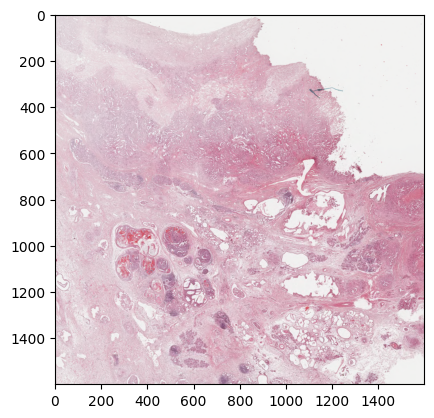

In [71]:
obj = slide.read_region(lu, 3, [1600,1600])
plt.imshow(obj)

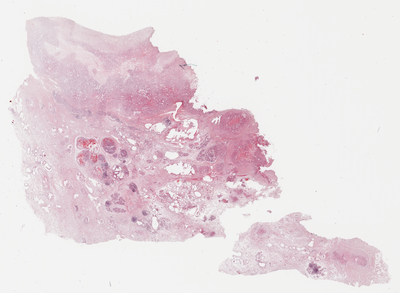

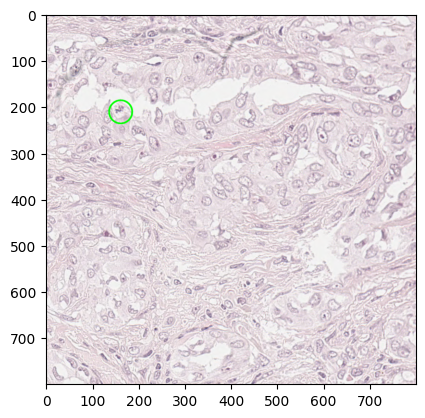

In [69]:
plt.imshow(img)

In [13]:
from SlideRunner.dataAccess.database import Database

DB = Database().open('databases/MITOS_WSI_CMC_COADEL_TR.sqlite')



In [32]:
len(DB.annotations.keys())
for anno in DB.annotations.keys():
    print(anno, ':', DB.annotations[anno].x1, DB.annotations[anno].y1, DB.annotations[anno].r)

24634 : 11761 6711 25
24635 : 11565 6978 25
24636 : 14133 7964 25
24637 : 18429 8768 25
24638 : 25264 8825 25
24640 : 8956 9850 25
24641 : 9440 9715 25
24642 : 17667 10372 25
24643 : 17867 10477 25
24644 : 17877 10416 25
24645 : 17952 10278 25
24646 : 18290 10489 25
24647 : 8095 11112 25
24648 : 8134 11087 25
24649 : 9144 10826 25
24650 : 8708 11052 25
24651 : 9424 11033 25
24652 : 19382 11321 25
24653 : 21578 11504 25
24654 : 26041 11410 25
24655 : 7965 12112 25
24656 : 9797 12173 25
24657 : 23407 12984 25
24658 : 9789 14139 25
24660 : 9922 14570 25
24661 : 10006 14602 25
24662 : 7749 14042 25
24663 : 11752 14450 25
24664 : 24501 14090 25
24666 : 31590 14043 25
24667 : 33462 14442 25
24668 : 11240 15017 25
24669 : 11217 15229 25
24670 : 10983 15237 25
24671 : 13260 14809 25
24672 : 17089 15028 25
24673 : 26058 15250 25
24674 : 34216 15289 25
24675 : 35586 15252 25
24676 : 9444 15741 25
24677 : 13018 15500 25
24678 : 16284 16109 25
24679 : 19534 16202 25
24680 : 8710 17063 25
24681 : 9

AttributeError: 'polygonAnnotation' object has no attribute 'x1'

In [30]:
list(DB.annotations.values())[0]

In [36]:
#type(DB.annotations[24634])
DB.annotations[24634].x1, DB.annotations[24634].y1, DB.annotations[24634].r


(11761, 6711, 25)

In [45]:
slide = openslide.open_slide('WSI/deb768e5efb9d1dcbc13.svs')


In [64]:
import matplotlib.pyplot as plt
import numpy as np
lu = (11600,6500)
img = np.array(slide.read_region( lu, 0, [800,800]))[:,:,0:4]

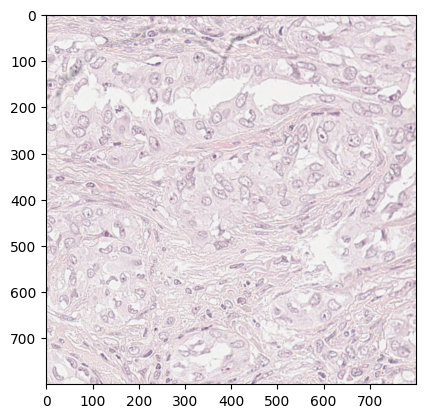

In [65]:
plt.imshow(img)

In [66]:
from SlideRunner.dataAccess.annotations import ViewingProfile
DB.annotations[24634].draw(image=img, leftUpper=lu, zoomLevel=1., thickness=2, vp=ViewingProfile())

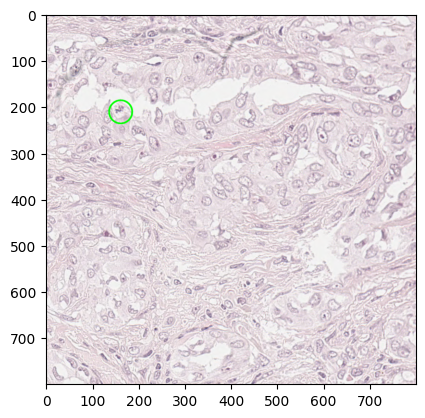

In [67]:
plt.imshow(img)